In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb

In [467]:
train = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/ML_For_Agriculture/Data/train_yaOffsB.csv")
test  = pd.read_csv("C:/Users/kulka/Desktop/AV_Hackathon_Codes/ML_For_Agriculture/Data/test_pFkWwen.csv")

In [468]:
"Training Data Shape:{}".format(train.shape),"Testing Data Shape:{}".format(test.shape) 

('Training Data Shape:(88858, 10)', 'Testing Data Shape:(59310, 9)')

In [469]:
Submission = test[['ID']]
train.drop("ID",axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)

In [470]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Estimated_Insects_Count  88858 non-null  int64  
 1   Crop_Type                88858 non-null  int64  
 2   Soil_Type                88858 non-null  int64  
 3   Pesticide_Use_Category   88858 non-null  int64  
 4   Number_Doses_Week        88858 non-null  int64  
 5   Number_Weeks_Used        79858 non-null  float64
 6   Number_Weeks_Quit        88858 non-null  int64  
 7   Season                   88858 non-null  int64  
 8   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 6.1 MB


In [471]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59310 entries, 0 to 59309
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Estimated_Insects_Count  59310 non-null  int64  
 1   Crop_Type                59310 non-null  int64  
 2   Soil_Type                59310 non-null  int64  
 3   Pesticide_Use_Category   59310 non-null  int64  
 4   Number_Doses_Week        59310 non-null  int64  
 5   Number_Weeks_Used        53417 non-null  float64
 6   Number_Weeks_Quit        59310 non-null  int64  
 7   Season                   59310 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.6 MB


1. No Object data types in the dataset.
2. There are missing values in one variable (Number_Weeks_Used).
3. Most of the variables are of type int.

In [472]:
train.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,188,1,0,1,0,0.0,0,1,0
1,209,1,0,1,0,0.0,0,2,1
2,257,1,0,1,0,0.0,0,2,1
3,257,1,1,1,0,0.0,0,2,1
4,342,1,0,1,0,0.0,0,2,1


#### Dependent Variable

In [473]:
train['Crop_Damage'].value_counts(dropna=False)/len(train)

0    0.835468
1    0.138502
2    0.026030
Name: Crop_Damage, dtype: float64

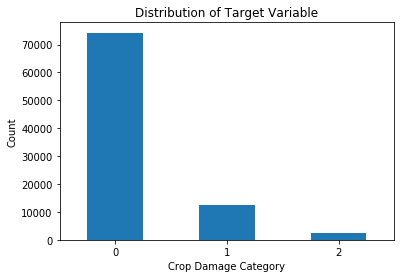

In [474]:
train['Crop_Damage'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Target Variable");
plt.xlabel("Crop Damage Category");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Looks like more than 90% of the crops are not damaged by the use of pesticides.
2. Merely 0.02% of the crops are damaged by the use of pesticides.
3. Around 14% are damaged due to reasons other than the use of pesticides.
4. The data clearly looks imbalanced.

#### Independent Variables.

In [475]:
train['Estimated_Insects_Count'].describe()

count    88858.000000
mean      1399.012210
std        849.048781
min        150.000000
25%        731.000000
50%       1212.000000
75%       1898.000000
max       4097.000000
Name: Estimated_Insects_Count, dtype: float64

1. Looks like a positively skewed distribution.
2. Minimum Insect count per square meter is 150 and maximum is 4097.
3. There seem to be some outliers that stand out from the rest.

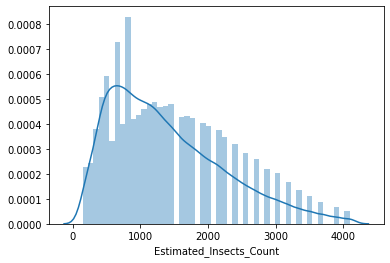

In [476]:
sns.distplot(train['Estimated_Insects_Count'])

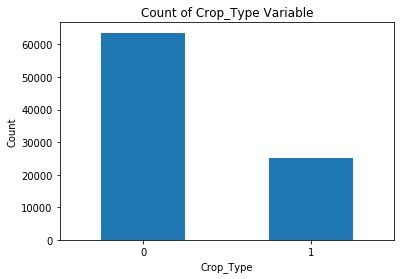

In [477]:
train['Crop_Type'].value_counts(dropna=False).plot.bar();
plt.title("Count of Crop_Type Variable");
plt.xlabel("Crop_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Looks like Crop_Type 0 is commonly occuring crop.

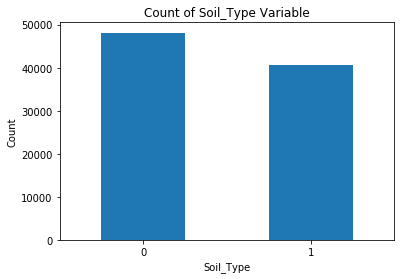

In [478]:
train['Soil_Type'].value_counts(dropna=False).plot.bar();
plt.title("Count of Soil_Type Variable");
plt.xlabel("Soil_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Looks like almost equal distribution here in the Soil Type variable.

In [479]:
train['Pesticide_Use_Category'].value_counts(dropna=False)/len(train)

2    0.716975
3    0.273605
1    0.009420
Name: Pesticide_Use_Category, dtype: float64

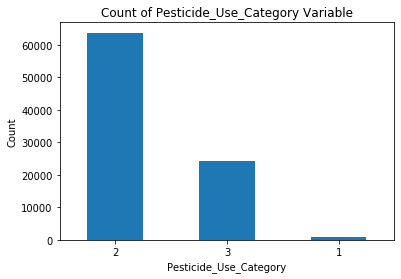

In [480]:
train['Pesticide_Use_Category'].value_counts(dropna=False).plot.bar();
plt.title("Count of Pesticide_Use_Category Variable");
plt.xlabel("Pesticide_Use_Category");
plt.ylabel("Count");
plt.xticks(rotation=360);

1. Looks like, the pesticide has been used, either in the past or is being used currently, rarely occassions when it is not used.

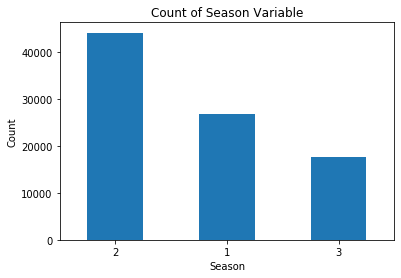

In [481]:
train['Season'].value_counts(dropna=False).plot.bar();
plt.title("Count of Season Variable");
plt.xlabel("Season");
plt.ylabel("Count");
plt.xticks(rotation=360);

In [482]:
train[['Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit']].describe()

,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit
count,88858.000000,79858.000000,88858.000000
mean,25.849952,28.623970,9.589986
std,15.554428,12.391881,9.900631
min,0.000000,0.000000,0.000000
25%,15.000000,20.000000,0.000000
50%,20.000000,28.000000,7.000000
75%,40.000000,37.000000,16.000000
max,95.000000,67.000000,50.000000


1. Maximum number of doses used per week is 95 and minimum is 0 (Which is as good as not used).
2. Maximum number of weeks the pesticide is used is 67 and minimum is 0 which again means the pesticide is not used. There are lot of missing values here which need to be imputed accordingly.

#### Bi-Variate Analysis

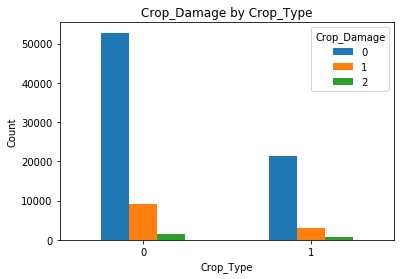

In [483]:
train.groupby("Crop_Type")['Crop_Damage'].value_counts().unstack().plot.bar();
plt.title("Crop_Damage by Crop_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

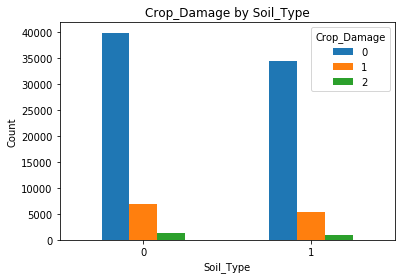

In [484]:
train.groupby("Soil_Type")['Crop_Damage'].value_counts().unstack().plot.bar();
plt.title("Crop_Damage by Soil_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

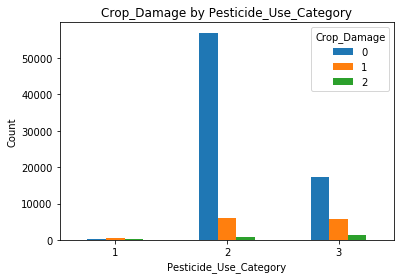

In [485]:
train.groupby("Pesticide_Use_Category")['Crop_Damage'].value_counts().unstack().plot.bar();
plt.title("Crop_Damage by Pesticide_Use_Category");
plt.ylabel("Count");
plt.xticks(rotation=360);

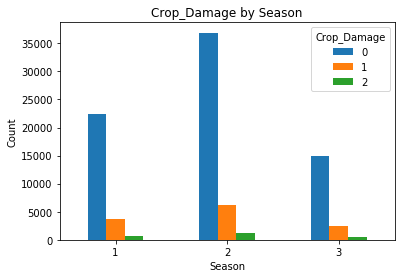

In [486]:
train.groupby("Season")['Crop_Damage'].value_counts().unstack().plot.bar();
plt.title("Crop_Damage by Season");
plt.ylabel("Count");
plt.xticks(rotation=360);

In [487]:
train.groupby("Crop_Damage")['Estimated_Insects_Count'].describe()

,count,mean,std,min,25%,50%,75%,max
Crop_Damage,,,,,,,,
0,74238.0,1315.707387,810.401587,150.0,677.0,1132.0,1785.0,4097.0
1,12307.0,1839.106200,924.065556,150.0,1132.0,1678.0,2541.0,4097.0
2,2313.0,1731.111976,841.805762,150.0,1056.0,1576.0,2267.0,4097.0


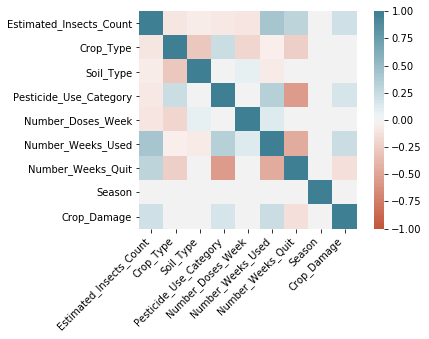

In [488]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Looks like Number_Of_Weeks_Quit and Number_Of_Weeks_Used have high correlation between themselves. 

Also looks like none of the variables are highly correlated to the dependent variable. 

In [489]:
train.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,188,1,0,1,0,0.0,0,1,0
1,209,1,0,1,0,0.0,0,2,1
2,257,1,0,1,0,0.0,0,2,1
3,257,1,1,1,0,0.0,0,2,1
4,342,1,0,1,0,0.0,0,2,1


In [490]:
for df in [train,test]:
    df['Number_Of_Weeks_Used_Missing'] = df['Number_Weeks_Used'].isna()

In [491]:
def insects_count_binning(x):
    if x<=1000:
        return "Low"
    elif (x>1000 and x<=2000):
        return "Medium"
    elif (x>2000 and x<=3000):
        return "High"
    else:
        return "Very_High"

def number_of_doses_binning(x):
    if x<=20:
        return "Low"
    elif (x>20 and x<=40):
        return "Medium"
    elif (x>40 and x<=60):
        return "High"
    else:
        return "Very_High"

train['Insects_Count_Bin'] = train['Estimated_Insects_Count'].apply(insects_count_binning)
test['Insects_Count_Bin'] = test['Estimated_Insects_Count'].apply(insects_count_binning)

train['Number_of_Doses_Bin'] = train['Number_Doses_Week'].apply(number_of_doses_binning)
test['Number_of_Doses_Bin'] = test['Number_Doses_Week'].apply(number_of_doses_binning)

le = LabelEncoder()
for df in [train,test]:
    df['Insects_Count_Bin'] = le.fit_transform(df['Insects_Count_Bin'])
    df['Number_of_Doses_Bin'] = le.fit_transform(df['Number_of_Doses_Bin'])

In [492]:
X = train[[col for col in train.columns if col!="Crop_Damage"]]
y = train['Crop_Damage']

In [493]:
KF = StratifiedKFold(n_splits=5,random_state=42)

C:\Users\kulka\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [494]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',num_class=3,random_state=42,n_jobs=-1,verbose=1)
params = {"max_depth":[4,6,8,10,-1],
          "learning_rate":[0.001,0.005,0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0,0.25,0.5,1,2],
          "reg_lambda":[0,0.25,0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,1001,100))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=KF.split(X,y),scoring='accuracy')
random_search.fit(X,y)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000019204368448>,
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=3, num_leaves=31,
                                            ob...
                                                          0.05, 0.1, 0.3],
                                        'max_depth': [4, 6, 8, 10, -1],
  

In [495]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
                importance_type='split', learning_rate=0.1, max_depth=4,
                min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=5,
                min_split_gain=0.0, n_estimators=650, n_jobs=-1, num_class=3,
                num_leaves=63, objective='multiclass', random_state=42,
                reg_alpha=2, reg_lambda=0, silent=True, subsample=0.7,
                subsample_for_bin=200000, subsample_freq=0, verbose=1),
 {'subsample': 0.7,
  'reg_lambda': 0,
  'reg_alpha': 2,
  'num_leaves': 63,
  'n_estimators': 650,
  'min_data_in_leaf': 5,
  'max_depth': 4,
  'learning_rate': 0.1,
  'colsample_bytree': 0.5},
 0.8469468044026695)

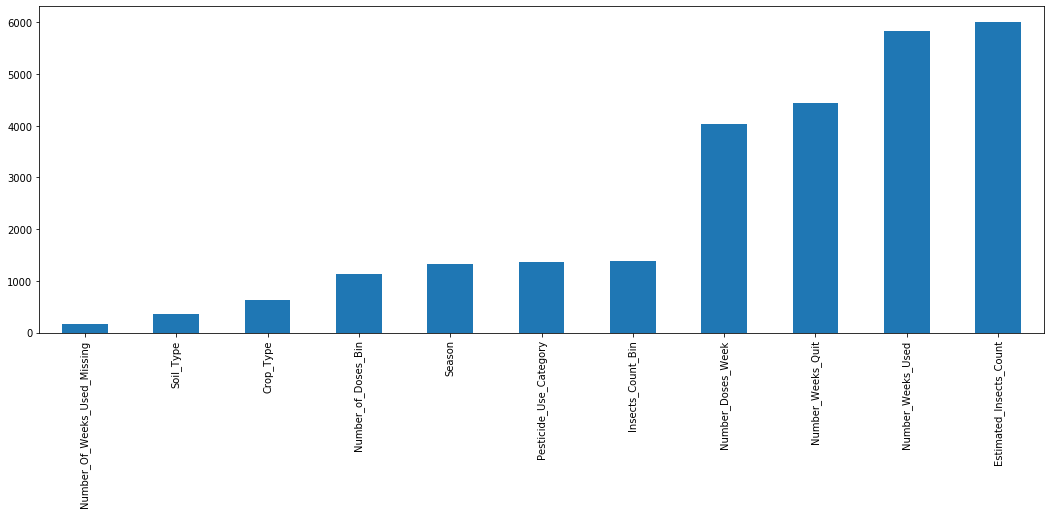

In [496]:
plt.figure(figsize=(18,6))
ser = pd.Series(random_search.best_estimator_.feature_importances_,X.columns).sort_values()
ser.plot(kind='bar')

In [497]:
Submission['Crop_Damage'] = random_search.best_estimator_.predict(test)
Submission.to_csv("Sub_6.csv",index=None)

C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [498]:
Submission['Crop_Damage'].value_counts()

0    56212
1     3096
2        2
Name: Crop_Damage, dtype: int64